*This 3rd and final activity before heading to Boulder works with a tile of AOP RGB data. Success with a couple test tasks will suggest I have correctly set up my machine and have entry level comfort working with Jupyter notebooks. 

# Settup and envrionment loading

In [5]:
import sys
sys.version

'3.5.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:11:22) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [12]:
import gdal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Define a read-in function

In [13]:
def RGBraster2array(RGB_geotif):
    """RGBraster2array reads in a NEON AOP geotif file and returns 
    a numpy array, and header containing associated metadata with spatial information.
    --------
    Parameters
        RGB_geotif -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    array:
        numpy array of geotif values
    metadata:
        dictionary containing the following metadata (all strings):
            array_rows
            array_cols
            bands
            driver
            projection
            geotransform 
            pixelWidth 
            pixelHeight 
            extent
            noDataValue  
            scaleFactor 
    --------
    Example Execution:
    --------
    RGB_geotif = '2017_SERC_2_368000_4306000_image.tif'
    RGBcam_array, RGBcam_metadata = RGBraster2array(RGB_geotif) """

    metadata = {}
    dataset = gdal.Open(RGB_geotif)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()

    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    for i in range(1, dataset.RasterCount+1):
        band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        band[band==metadata['noDataValue']]=np.nan
        band = band/metadata['scaleFactor']
        array[...,i-1] = band

    return array, metadata

# Load data

In [15]:
RGB_geotif='./data/2017_SERC_2_368000_4306000_image.tif'
SERC_RGBcam_array, SERC_RGBcan_metadata = RGBraster2array(RGB_geotif)

## check that it worked!

In [17]:
SERC_RGBcam_array.shape

(10000, 10000, 3)

In [21]:
for key in sorted(SERC_RGBcan_metadata.keys()):
    print(key)

array_cols
array_rows
bands
driver
ext_dict
extent
geotransform
noDataValue
pixelHeight
pixelWidth
projection
scaleFactor


# Define a plot function

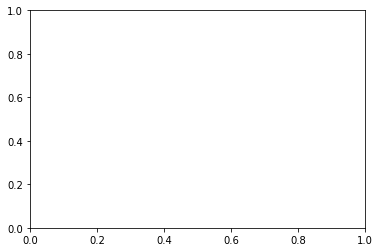

In [103]:
def plot_band_array(band_array,
                    refl_extent,
                    colorlimit,
                    ax=plt.gca(),
                    title='',
                    cbar ='on',
                    cmap_title='',
                    colormap='spectral'):

    '''plot_band_array reads in and plots a single band or an rgb band combination of a reflectance array
    --------
    Parameters
    --------
        band_array: flightline array of reflectance values, created from h5refl2array function
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) - use metadata['extent'] from h5refl2array function
        colorlimit: range of values to plot (min,max). Best to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: string, optional; plot title
        cmap_title: string, optional; colorbar title
        colormap: string, optional; see https://matplotlib.org/examples/color/colormaps_reference.html for list of colormaps
    --------
    Returns 
        plots array of single band or RGB if given a 3-band 
    --------
    Example:
    --------
    plot_band_array(SERC_RGBcam_array, 
                    SERC_RGBcam_metadata['extent'],
                    (1,255),
                    title='SERC RGB Camera Tile',
                    cbar='off')'''

    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

# Render RGB image and plot histograms

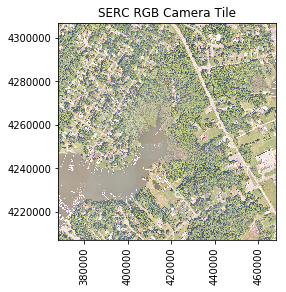

In [71]:
plot_band_array(SERC_RGBcam_array,
               SERC_RGBcan_metadata['extent'],
               (5,255),
               title='SERC RGB Camera Tile',
               cbar='off')

Text(0,0.5,'Frequency')

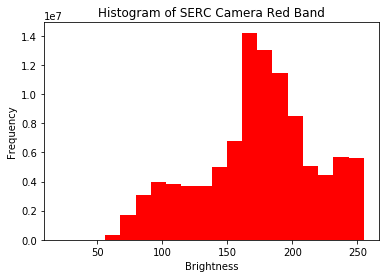

In [28]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,0]),20,facecolor='r');
plt.title('Histogram of SERC Camera Red Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

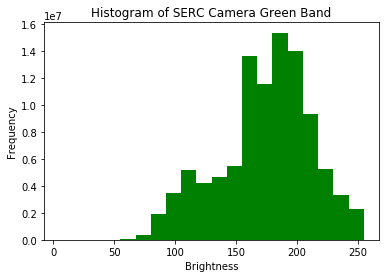

In [29]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,1]),20,facecolor='g');
plt.title('Histogram of SERC Camera Green Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

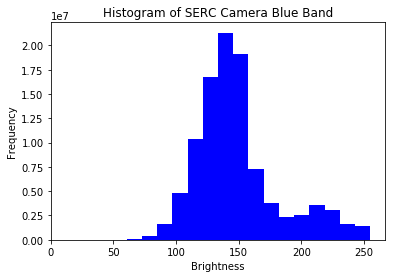

In [30]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,2]),20,facecolor='b');
plt.title('Histogram of SERC Camera Blue Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

# Extract reflectance range for each band

In [88]:
rmin=np.amin(SERC_RGBcam_array[:,:,0])
rmax=np.amax(SERC_RGBcam_array[:,:,0])
print( "red: " + str(rmin) + " - " + str(rmax))

red: 21 - 255


In [90]:
gmin=str(np.amin(SERC_RGBcam_array[:,:,1]))
gmax=str(np.amax(SERC_RGBcam_array[:,:,1]))
print( "green: " + str(gmin) + " - " + str(gmax))

green: 5 - 255


In [91]:
bmin=np.amin(SERC_RGBcam_array[:,:,2])
bmax=np.amax(SERC_RGBcam_array[:,:,2])
print( "blue: " + str(bmin) + " - " + str(bmax))

blue: 12 - 255


# Extract UTM zone from meta data

In [64]:
SERC_RGBcan_metadata['projection'].split()[5].split(',')[0]

'18N"'

# Plot single color channels

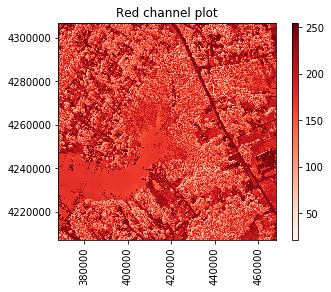

In [99]:
plot_band_array(SERC_RGBcam_array[:,:,0],
               SERC_RGBcan_metadata['extent'],
               (rmin,rmax),
               title='Red channel plot',
               cbar='on',colormap='Reds')

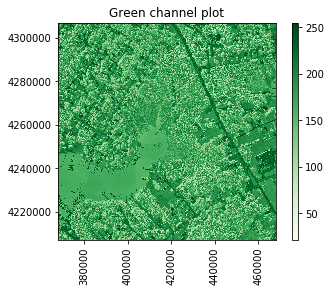

In [100]:
plot_band_array(SERC_RGBcam_array[:,:,1],
               SERC_RGBcan_metadata['extent'],
               (rmin,rmax),
               title='Green channel plot',
               cbar='on',colormap='Greens')

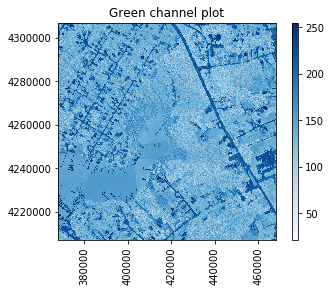

In [102]:
plot_band_array(SERC_RGBcam_array[:,:,2],
               SERC_RGBcan_metadata['extent'],
               (rmin,rmax),
               title='Green channel plot',
               cbar='on',colormap='Blues')